## nn.Sequential を使って層を生成する

In [1]:
import torch
import torch.nn as nn

In [2]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

* 活性化関数の選択
  * https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
* `nn.init` による層のパラメータの初期化
  * https://pytorch.org/docs/stable/nn.init.html
* `torch.optim` のオプションのオプティマイザで `weight_decay` パラメータを使った層のパラメータに対する `L2` 正則化の適用（過学習の抑制）
  * https://pytorch.org/docs/stable/optim.html
* 損失テンソルにL1 ペナルティ項を追加することによる層のぺらめーたに対するL1正則化の適用（過学習の抑制：以下で適用）

In [3]:
nn.init.xavier_uniform_(model[0].weight)  # 一つ目の線形層の重みの初期化
l1_weitht = 0.01
li_penalty = l1_weitht * model[2].weight.abs().sum()  # 二つ目の線形層の L1 重み

In [4]:
# 損失関数の選択
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### XOR 分類問題を解く
XOR 分類問題... 二つのクラス間での非線形の決定境界の補足（線形分離がそもそも不可能なセッティング）

In [5]:
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
n_train = 100
y[x[:, 0] * x[:, 1] < 0] = 0

x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

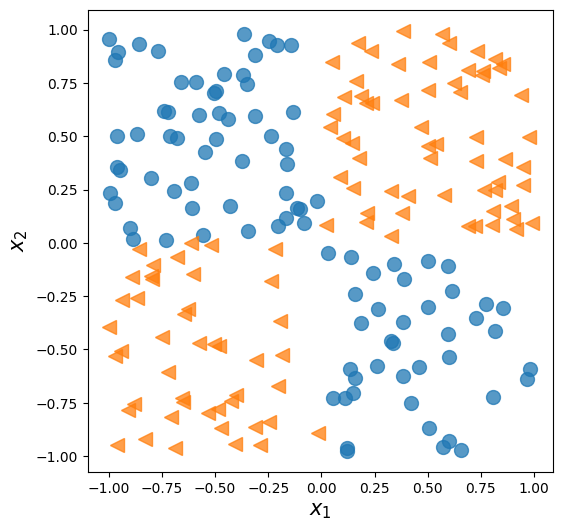

In [6]:
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y == 0, 0], x[y == 0, 1], "o", alpha=0.75, markersize=10)
plt.plot(x[y == 1, 0], x[y == 1, 1], "<", alpha=0.75, markersize=10)
plt.xlabel(r"$x_1$", size=15)
plt.ylabel(r"$x_2$", size=15)
plt.show()

## ベースラインとしてロジスティック回帰を実装する

ある程度以上は精度が改善しない

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [8]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid(),
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [9]:
torch.manual_seed(1)
num_epochs = 200


def train(model, num_epochs, loss_fn, optimizer, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred > 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train / batch_size
        accuracy_hist_train[epoch] /= n_train / batch_size
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred > 0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


history = train(model, num_epochs, loss_fn, optimizer, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

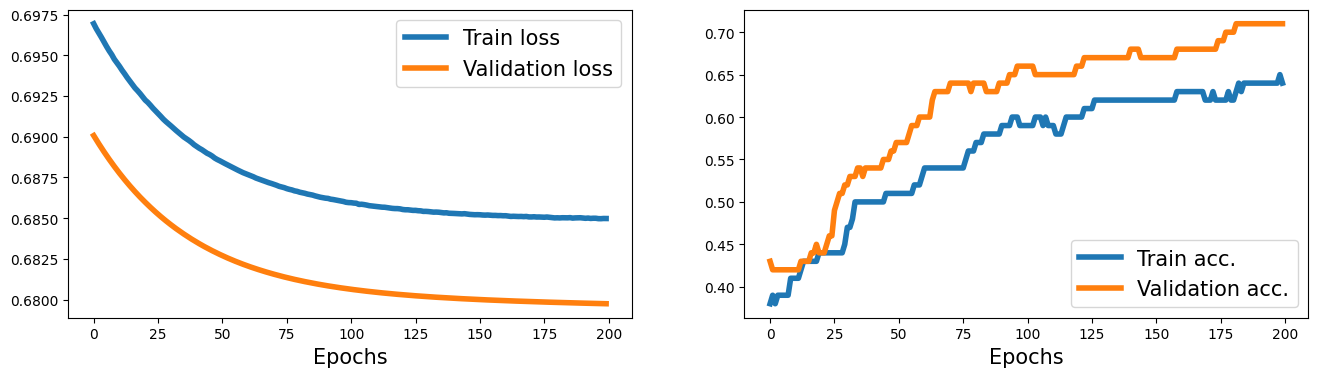

In [10]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

## 隠れ層の追加

In [11]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid(),
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

In [12]:
history = train(model, num_epochs, loss_fn, optimizer, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

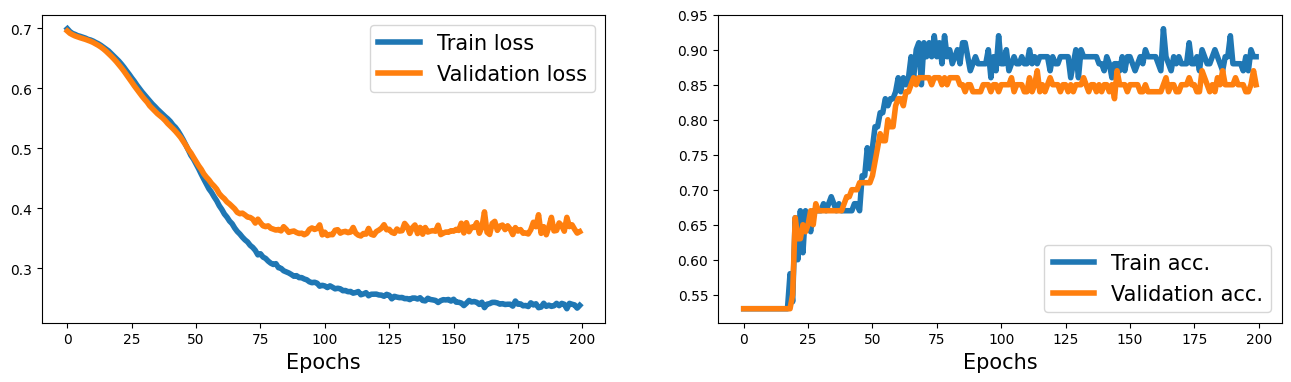

In [13]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

## nn.Molude を用いたモデルの定義

複数の入出力や分岐を持つようなモデルを効率よく作る

In [14]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        li = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(li)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

In [15]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [16]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, loss_fn, optimizer, train_dl, x_valid, y_valid)

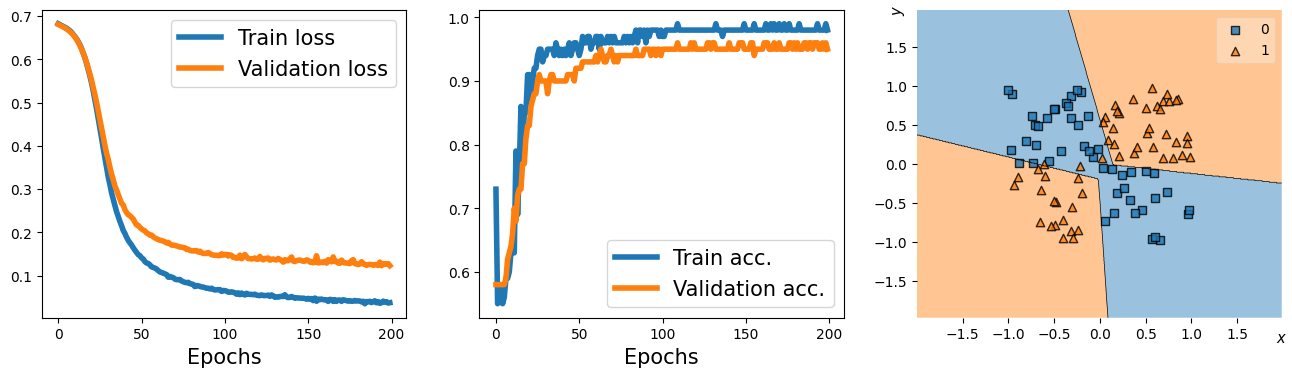

In [17]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int64), clf=model)
ax.set_xlabel(r"$_x$", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$_y$", size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## PyTorch でカスタム層を記述する

In [18]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        # nn.Pareameters はモジュールパラメータを表すテンソル
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)

        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

In [19]:
torch.manual_seed(2)
noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

tensor([[ 0.0249, -0.0517]], grad_fn=<AddBackward0>)


In [20]:
print(noisy_layer(x, training=True))

tensor([[ 0.0102, -0.0144]], grad_fn=<AddBackward0>)


In [21]:
print(noisy_layer(x, training=False))

tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [22]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

In [23]:
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [24]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, loss_fn, optimizer, train_dl, x_valid, y_valid)

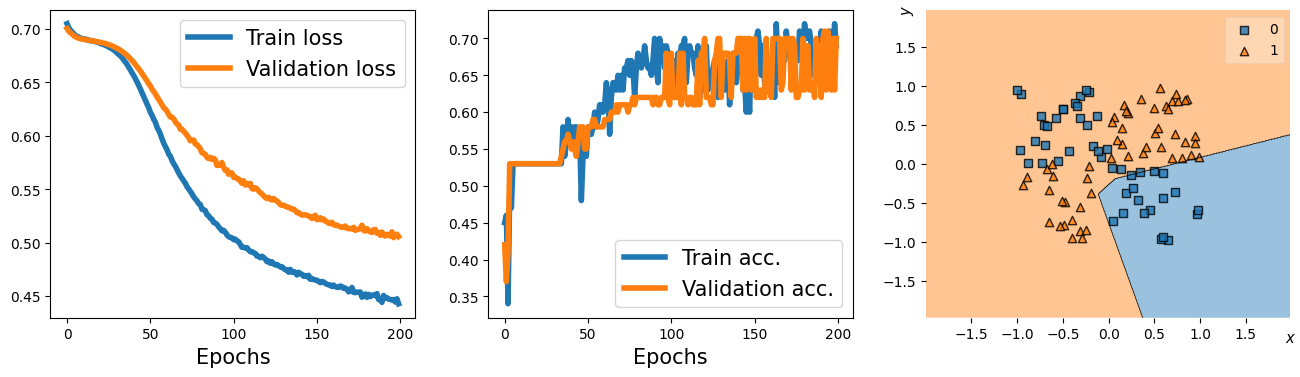

In [25]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int64), clf=model)
ax.set_xlabel(r"$_x$", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$_y$", size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()